## Разрешимость XOR с помощью двух нейронов вместо трех

Обычно при обьяснении проблемы XOR указывают, что один нейрон с такой задачей не справляется (линейно неразделимы точки), и предлагается можель из трех нейронов (два в первом слое и один во втором), которая справляется с задачей. В трехнейронной модели имеется 9 весовых коэффициентов (включая bias). Однако я покажу как справится с XOR всего в два нейрона с 5-ю весовыми коэффициентами. Идея заключается в том, что на вход выходного нейрона подаем выход первого вместе с "копией" входного вектора: 

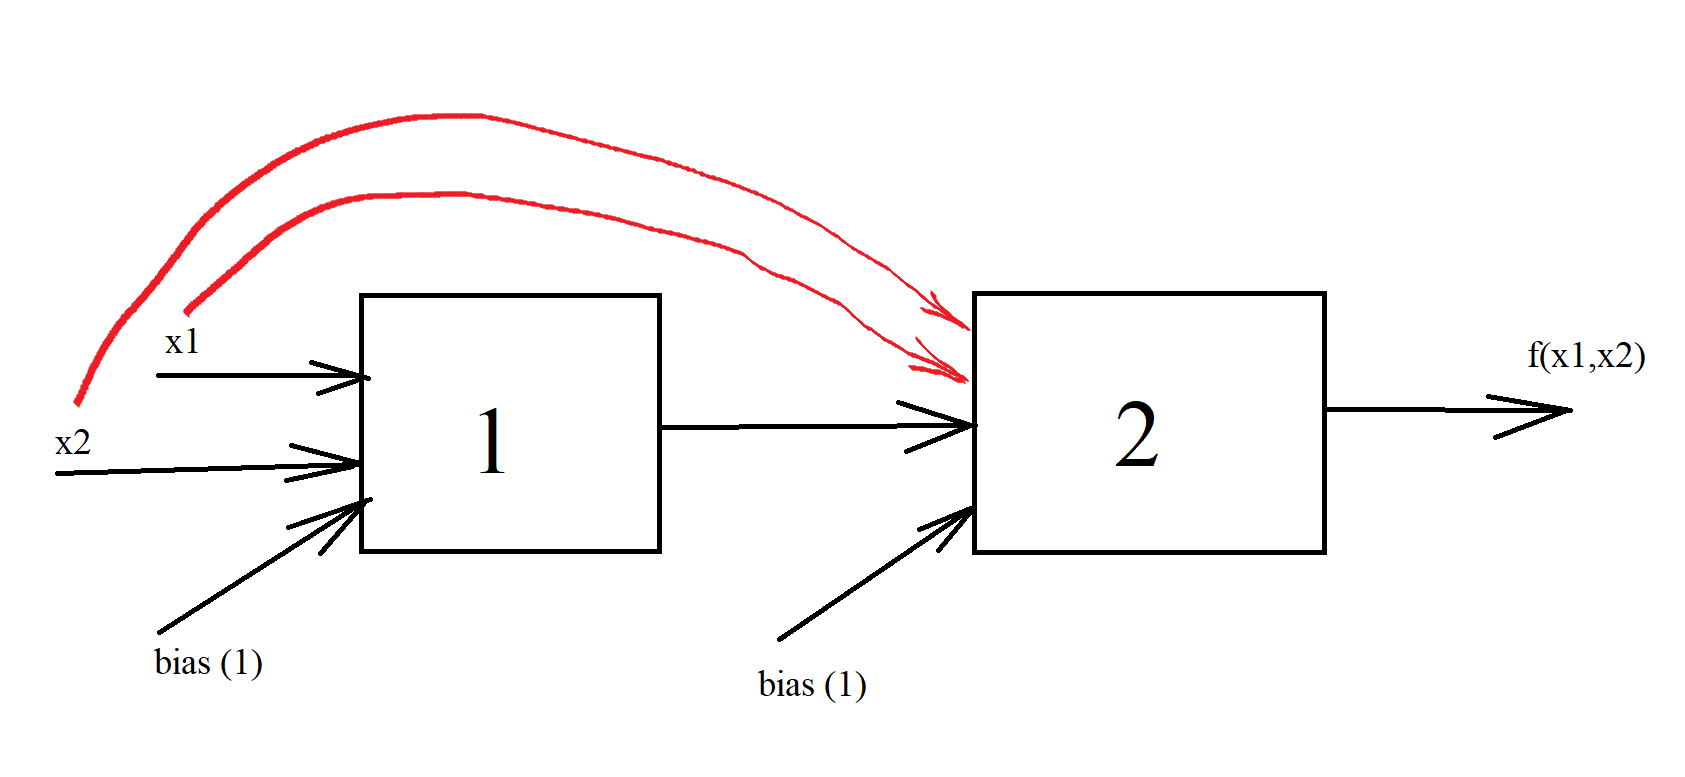

Сначала импортируем библиотеки и подготовим данные. Используем библиотеку TRAX.

In [ ]:
# установка trax (пока что в Colab он не установлен по умолчанию)
!pip install trax

In [ ]:
import trax
from trax import layers as tl
from trax.supervised import training
from trax.fastmath import numpy as np
import os

# все 4 возможных набора входных данных
x=np.array([[0,0],
            [0,1],
            [1,0],
            [1,1]])

# все 16 вариантов таблиц истинности логической функции двух переменных
y=np.array([[0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1],
            [0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1],
            [0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],
            [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1]])

# для модели trax нужен генератор данных 
def data_generator(x,y):
  while True:
    yield x,y,np.ones((y.shape))

INFO:tensorflow:tokens_length=568 inputs_length=512 targets_length=114 noise_density=0.15 mean_noise_span_length=3.0 


/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Функция, которая получает модель и обучает ее для всех вариантов таблицы истинности логической функции двух переменных:


In [ ]:

def trainModel(model,x,y,output_dir='model/'):
  
  res=[]
  for i in range(y.shape[1]):                               # перебираем таблицу истинности (обучаем в цикле модель 16 раз) 
    if os.path.exists("/content/model/model.pkl.gz"):
        os.remove("/content/model/model.pkl.gz")            # поскольку модель обучаем в цикле 16 раз, удаляем данные предыдущего обучения 
    model.init_weights_and_state(x)                         # и инициализируем весовые коэффициенты 


    train_task = training.TrainTask( labeled_data=data_generator(x,y[:,[i]]),            # входные данные - х и i-я таблица истинности 
          loss_layer=tl.metrics.L2Loss(),         
          optimizer=trax.optimizers.Adam(learning_rate=0.085,weight_decay_rate=0.00015),
      )  

    training_loop = training.Loop(model,train_task,output_dir=output_dir)                # готовим обучающий цикл (модель + данные)

    training_loop.run(4000)                                                              # обычно и 400 шагов достаточно, но для самых сложных задач обеспечим 4000 шагов (эпох)

    preds=(model(x)>0.5)+0                     # вычисляем результат для входных данных
    acc=float(np.mean(preds==y[:,[i]]))        # и сравниваем с i-й таблицей истинности
    res.append(acc)

  print("Accuracy:")
  print(res)
  res=np.array(res)<0.9
  print("Untrained functions:" )
  print(y[:,res])
  return res 


## Один нейрон (регрессия)

Попробуем работу функции обучения на одном нейроне (регрессия)

In [ ]:
model=tl.Serial(tl.Dense(1),tl.Sigmoid())
res=trainModel(model,x,y)


Accuracy:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Untrained functions:
[[0 1]
 [1 0]
 [1 0]
 [0 1]]


В полученном результате модель не смогла обучится двум таблицам истинности из 16, а именно "исключающему или" (XOR) [0 1 1 0] и эквивалентности [1 0 0 1]. Это соответствует ожиданиям - эти два набора точек линейно не разделимы. 

### Три нейрона (2+1)

Теперь попробуем модель из трех нейронов, ожидая успешное обучение любой таблице истинности двух переменных

In [ ]:
model=tl.Serial(tl.Dense(2),tl.Elu(),tl.Dense(1),tl.Sigmoid())
res=trainModel(model,x,y)


Accuracy:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Untrained functions:
[]


Модель обучается любой функции трех переменных.
Теперь эту же модель трех нейронов переделаем вручную из двухнейронного первого слоя Dense(2) в три отдельных нейрона, соединенных паралельно, результаты которых обьединяем в один тензор слоем Concatenate перед подачей на третий нейрон

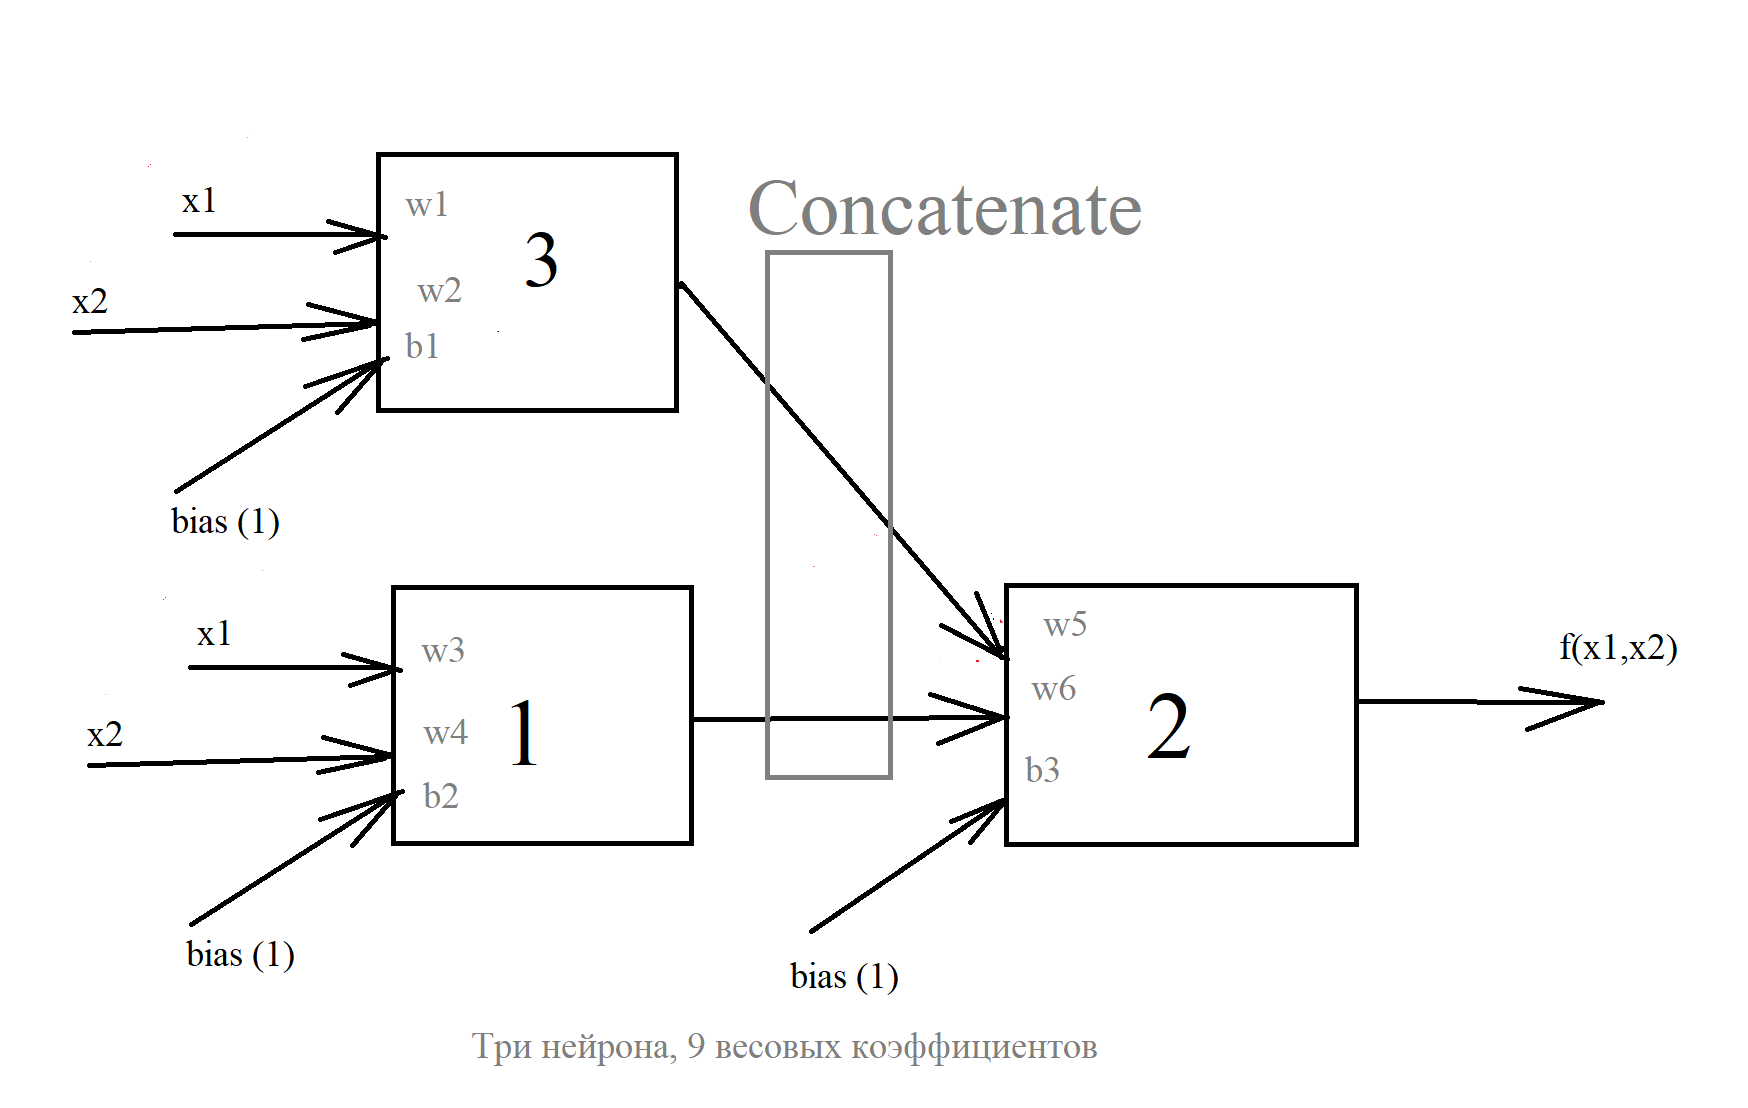

In [ ]:
Neuron1=tl.Serial(tl.Dense(1),tl.Elu())
Neuron3=tl.Serial(tl.Dense(1),tl.Elu())
Neuron2=tl.Serial(tl.Dense(1),tl.Sigmoid())

concat=trax.layers.combinators.Concatenate()

model=tl.Serial(tl.Branch(Neuron1,Neuron3),concat,Neuron2)

res=trainModel(model,x,y)

Accuracy:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Untrained functions:
[]


Модель работает как и предыдущая, и с помощью model.weights можно убедиться что число весовых коэффициентов тоже 9

## Переход к двум нейронам

В предыдущей модели один из нейронов первого слоя заменим на None - в этом случае входные сигналы непосредственно передаются на выход без изменений.

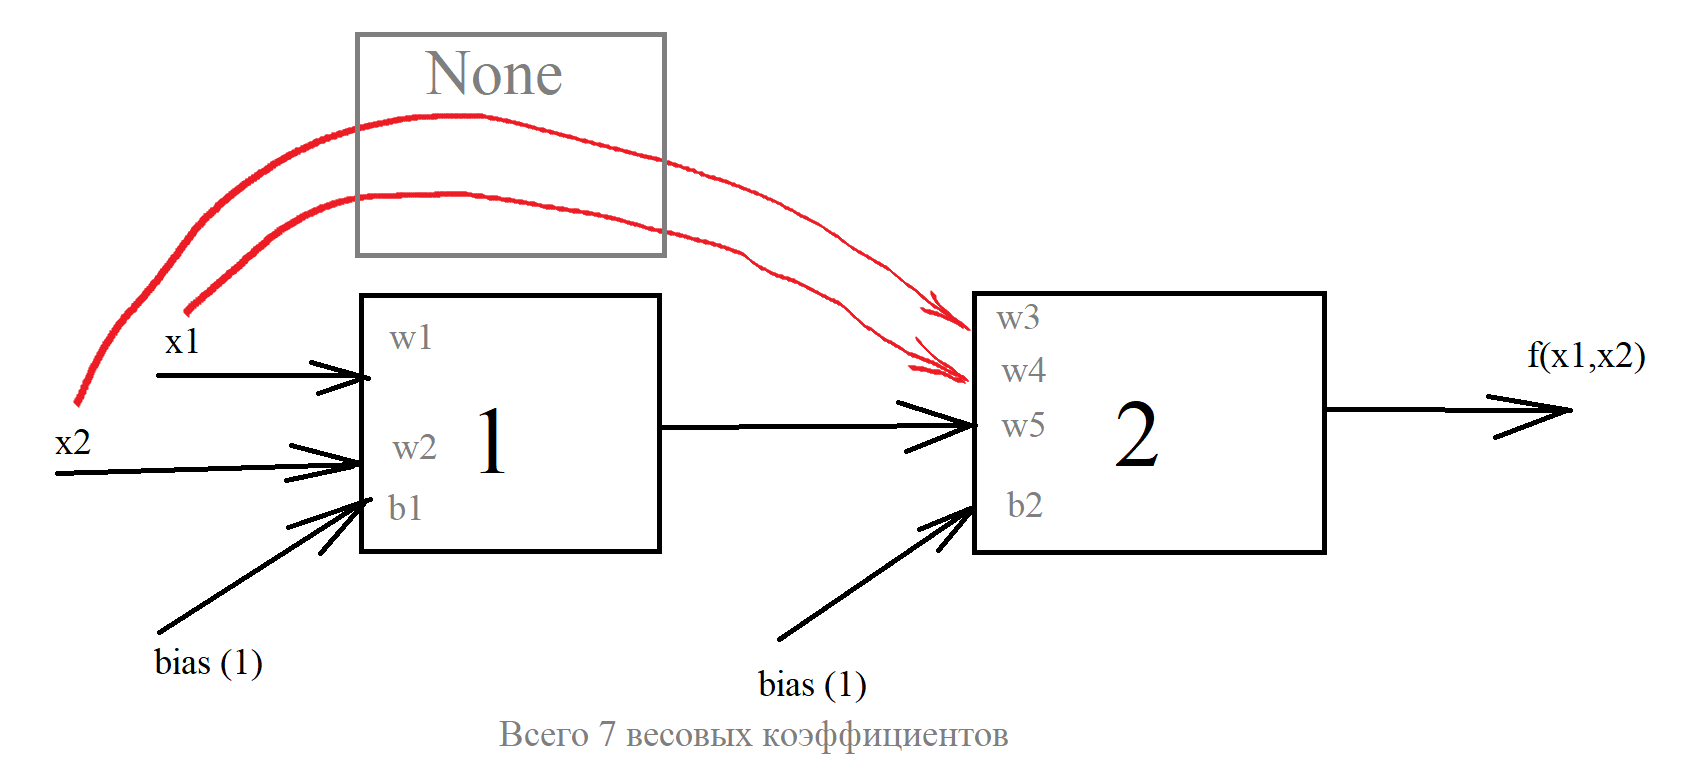

In [ ]:
Neuron1=tl.Serial(tl.Dense(1),tl.Elu())
Neuron2=tl.Serial(tl.Dense(1),tl.Sigmoid())

concat=trax.layers.combinators.Concatenate()

model=tl.Serial(tl.Branch(Neuron1,None),concat,Neuron2)

res=trainModel(model,x,y)

Accuracy:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Untrained functions:
[]


Работает! Только в нашем случае имеется 7 весовых коэффициентов (три у первого нейрона, и 4 у второго, так как он получает х1 х2 и выход первого нейрона + bias)

## Уменьшение числа весовых коэффициентов

Вместо того, чтобы на вход второго нейрона подавать весь входной сигнал (х1 х2), можно подать его среднее значение (Mean), нейроном этот обьект назвать невозможно так как отсутствуют весовые коэффициенты и нелинейность. Вместо ELU используем новенькую нелинейность GELU (GAUSSIAN ERROR LINEAR UNIT). Так обучится более быстро при любых вариантах инициализации. Хотя работает как ELU так и sigmoid

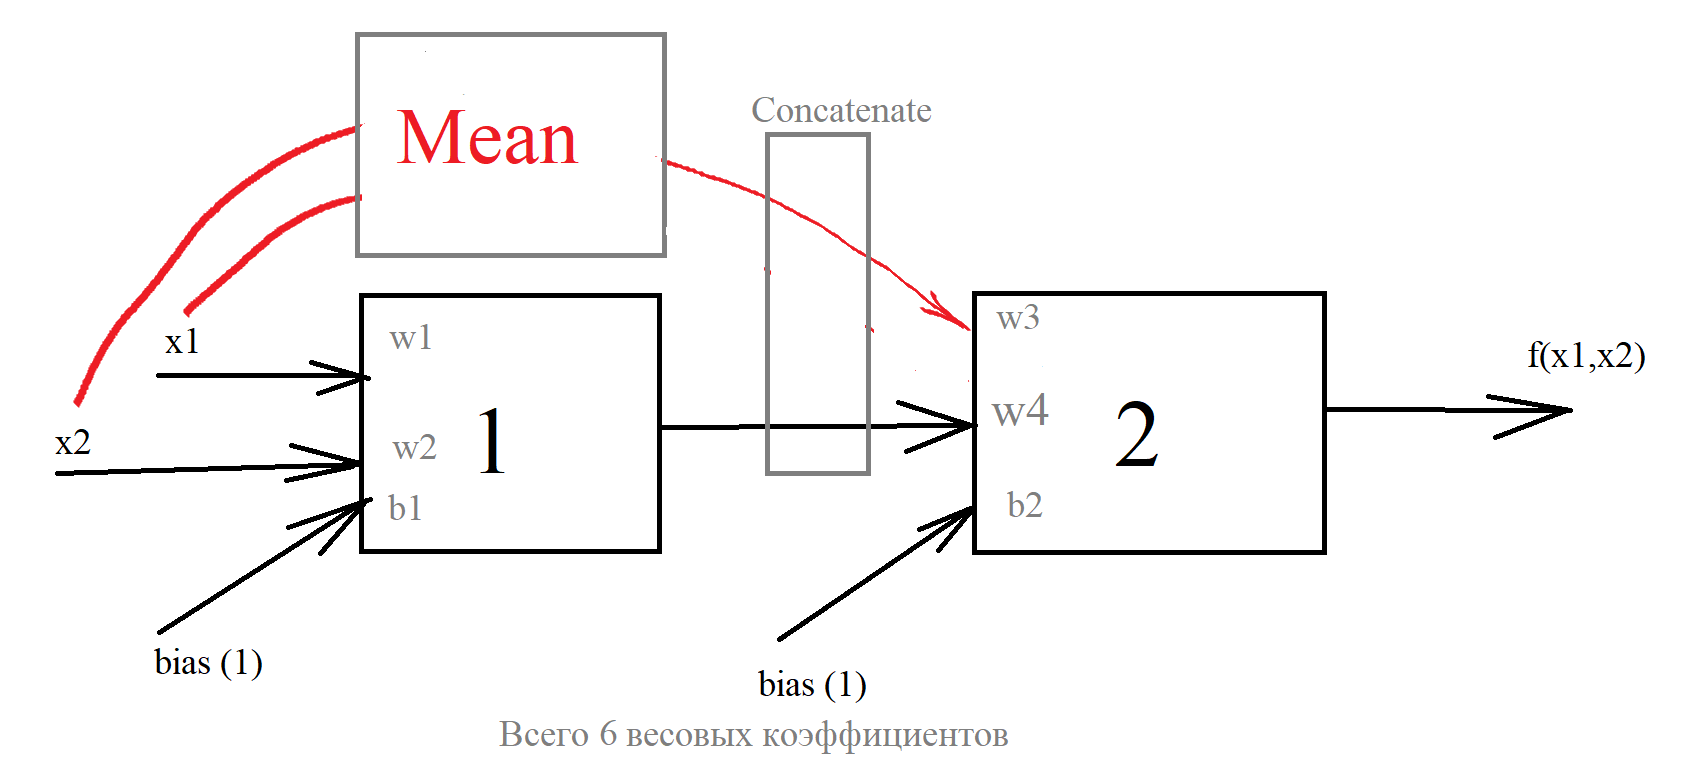

In [ ]:
Neuron1=tl.Serial(tl.Dense(1),tl.Gelu())
Neuron2=tl.Serial(tl.Dense(1),tl.Sigmoid())

concat=trax.layers.combinators.Concatenate()

model=tl.Serial(tl.Branch(Neuron1,tl.Mean(axis=-1,keepdims=True)),concat,Neuron2)

res=trainModel(model,x,y)

Accuracy:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Untrained functions:
[]


In [ ]:
model.weights # проверим число весовых коэффициентов

(((), (((DeviceArray([[0.53716326],
                  [1.0229198 ]], dtype=float32),
     DeviceArray([1.6887612], dtype=float32)),
    ()),
   ())),
 (),
 ((DeviceArray([[3.2805703 ],
                [0.13650544]], dtype=float32),
   DeviceArray([0.95819074], dtype=float32)),
  ()))

Работает, и число весовых коэффициентов теперь 6 (по три у каждого нейрона)

Теперь убираем bias у первого нейрона

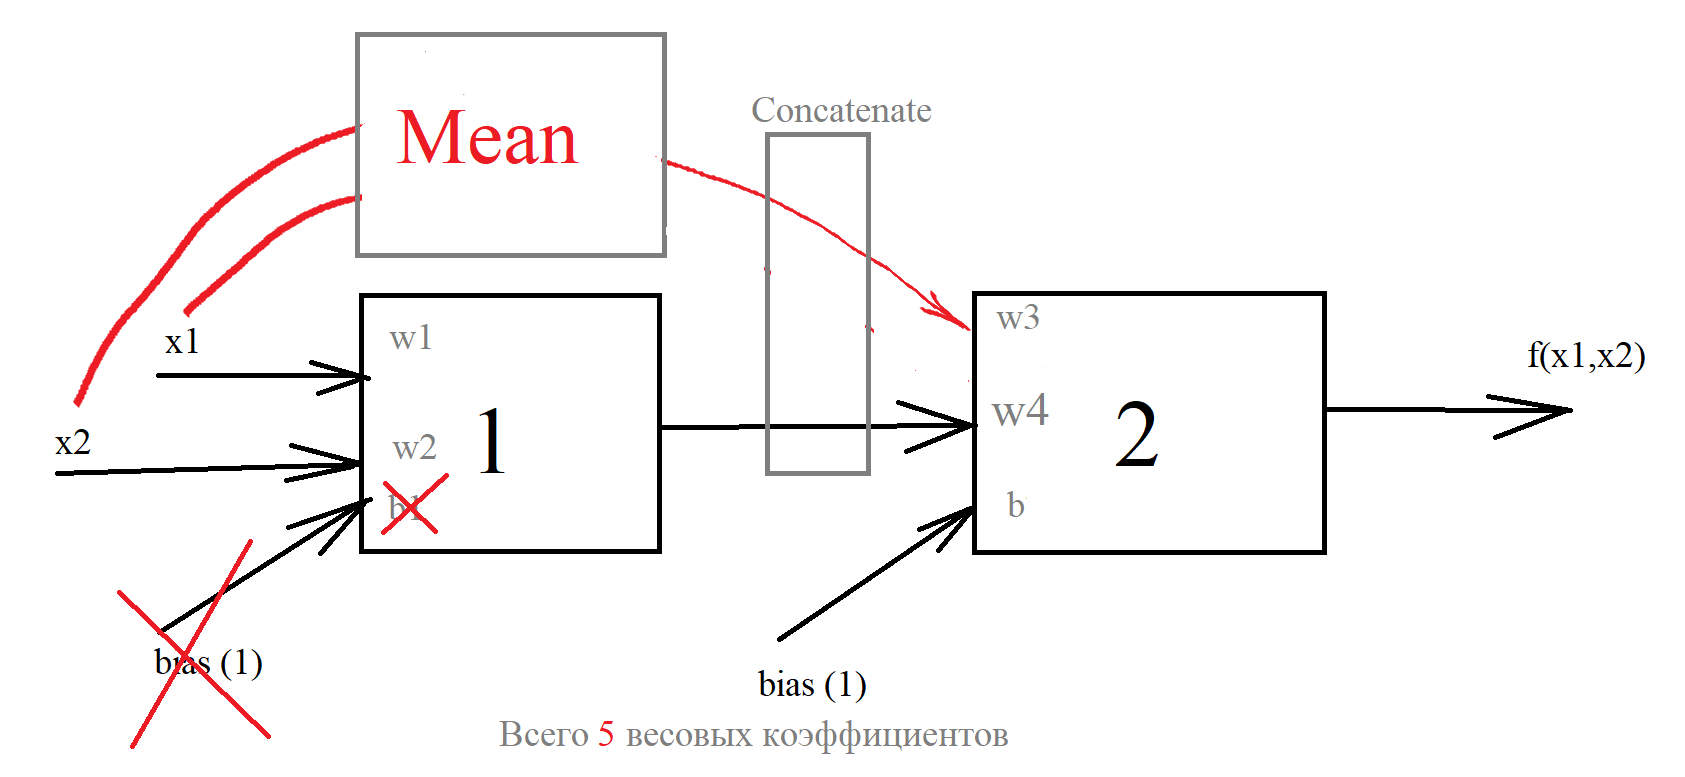

In [ ]:
Neuron1=tl.Serial(tl.Dense(1,use_bias=False),tl.Gelu())
Neuron2=tl.Serial(tl.Dense(1,use_bias=True),tl.Sigmoid())

concat=trax.layers.combinators.Concatenate()

model=tl.Serial(tl.Branch(Neuron1,tl.Mean(axis=-1,keepdims=True)),concat,Neuron2)

res=trainModel(model,x,y)

Accuracy:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Untrained functions:
[]


In [ ]:
model.weights # проверим число весовых коэффициентов

(((), ((DeviceArray([[-0.6851336 ],
                 [-0.65302694]], dtype=float32), ()), ())),
 (),
 ((DeviceArray([[-1.9714437],
                [ 1.9214795]], dtype=float32),
   DeviceArray([5.013004], dtype=float32)),
  ()))

Опять же работает, и осталось 5 весовых коэффициентов


## Двухнейронная модель с Tensorflow

(вариант с 7-ми весовыми коэффициентами)

In [ ]:
import tensorflow as tf
import numpy 

x=numpy.array([[0,0],
            [0,1],
            [1,0],
            [1,1]])

y=numpy.array([[0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1],
            [0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1],
            [0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],
            [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1]])


res=[]
for i in range(y.shape[1]):
    model=None
    inputs = tf.keras.Input(shape=(2,))
    xx = tf.keras.layers.Dense(1, activation="sigmoid")(inputs)
    xx=  tf.keras.layers.concatenate([xx, inputs], axis=-1)
    outputs  = tf.keras.layers.Dense(1, activation="sigmoid")(xx)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="TwoNeurons")    
    model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss="mse")
    
    model.fit(x,y[:,[i]], epochs=2000, verbose=0)
    preds=(model.predict(x)>0.5)+0
    acc=float(numpy.mean(preds==y[:,[i]]))
    res.append(acc)

print("Accuracy:")
print(res)
res=numpy.array(res)<0.9
print("Untrained functions:" )
print(y[:,res])



Accuracy:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Untrained functions:
[]


Модель обучается любой из 16 таблиц истинности логической функции двух переменных

In [ ]:
model.summary()

Model: "TwoNeurons"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 1)            3           input_16[0][0]                   
__________________________________________________________________________________________________
concatenate_15 (Concatenate)    (None, 3)            0           dense_30[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 1)            4           concatenate_15[0][0]    

### Заключение

Для решения XOR достаточно двух нейронов имеющих суммарно 5 весовых коэффициентов.